In [2]:
import numpy as np
import os
import sys
import tarfile
import pickle
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mimage
%matplotlib inline 

from six.moves.urllib.request import urlretrieve

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '../input_data/notMnist/' # Change me to store data elsewhere

In [4]:
def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

In [5]:
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

In [6]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ../input_data/notMnist/notMNIST_large.tar.gz
Found and verified ../input_data/notMnist/notMNIST_small.tar.gz


In [17]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

In [18]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

../input_data/notMnist/notMNIST_large already present - Skipping extraction of ../input_data/notMnist/notMNIST_large.tar.gz.
['../input_data/notMnist/notMNIST_large/A', '../input_data/notMnist/notMNIST_large/B', '../input_data/notMnist/notMNIST_large/C', '../input_data/notMnist/notMNIST_large/D', '../input_data/notMnist/notMNIST_large/E', '../input_data/notMnist/notMNIST_large/F', '../input_data/notMnist/notMNIST_large/G', '../input_data/notMnist/notMNIST_large/H', '../input_data/notMnist/notMNIST_large/I', '../input_data/notMnist/notMNIST_large/J']
../input_data/notMnist/notMNIST_small already present - Skipping extraction of ../input_data/notMnist/notMNIST_small.tar.gz.
['../input_data/notMnist/notMNIST_small/A', '../input_data/notMnist/notMNIST_small/B', '../input_data/notMnist/notMNIST_small/C', '../input_data/notMnist/notMNIST_small/D', '../input_data/notMnist/notMNIST_small/E', '../input_data/notMnist/notMNIST_small/F', '../input_data/notMnist/notMNIST_small/G', '../input_data/no

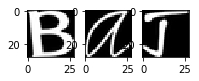

In [19]:
plt.figure(figsize=(5, 5))

plt.subplot(5, 5, 1)
fig = mimage.imread("../input_data/notMnist/notMNIST_large/B/Q0sgRXZvbHV0aW9uLnR0Zg==.png")
plt.imshow(fig, cmap="gray")

plt.subplot(5, 5, 2)
fig = mimage.imread("../input_data/notMnist/notMNIST_large/A/Q0sgU2NyaXB0LnR0Zg==.png")
plt.imshow(fig, cmap="gray")

plt.subplot(5, 5, 3)
fig = mimage.imread("../input_data/notMnist/notMNIST_large/J/Q0sgRm9ydHVuZS50dGY=.png")
plt.imshow(fig, cmap="gray")

plt.show()

In [20]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

In [21]:
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

In [22]:
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

../input_data/notMnist/notMNIST_large/A.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/B.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/C.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/D.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/E.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/F.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/G.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/H.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/I.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_large/J.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_small/A.pickle already present - Skipping pickling.
../input_data/notMnist/notMNIST_small/B.pickle already present - Skipping pi

## Challenge 2:


In [49]:
train_data = []
test_data = []
for data_set in train_datasets:
    train_data.append(pickle.load(open(data_set, "rb")))
for data_set in test_datasets:
    test_data.append(pickle.load(open(data_set, "rb")))

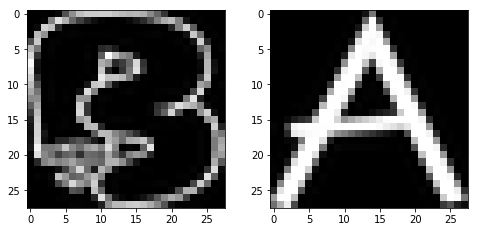

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(train_data[1][122], cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(train_data[0][1452], cmap="gray")

## Challenge 3:


In [63]:
for i in range(10):
    print(f"Train data for {i} => {len(train_data[i])}")
    print(f"Test data for {i} => {len(test_data[i])}")

Train data for 0 => 52909
Test data for 0 => 1872
Train data for 1 => 52911
Test data for 1 => 1873
Train data for 2 => 52912
Test data for 2 => 1873
Train data for 3 => 52911
Test data for 3 => 1873
Train data for 4 => 52912
Test data for 4 => 1873
Train data for 5 => 52912
Test data for 5 => 1872
Train data for 6 => 52912
Test data for 6 => 1872
Train data for 7 => 52912
Test data for 7 => 1872
Train data for 8 => 52912
Test data for 8 => 1872
Train data for 9 => 52911
Test data for 9 => 1872


In [74]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [75]:
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels

In [76]:
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


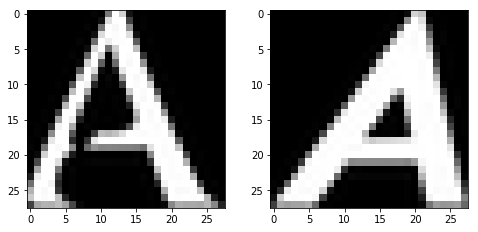

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(train_dataset[189], cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(train_dataset[345], cmap="gray")  

In [78]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4 :

#### Verification

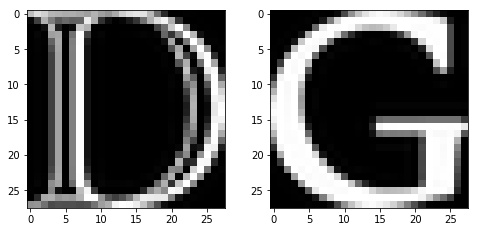

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(train_dataset[189], cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(train_dataset[345], cmap="gray")                                

In [80]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [81]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506
